# 0.0 LOCAL Eluvio Option 1 

**By: Vignesh Ravindranath**

`TODO`

Welcome to my report for the Eluvio DS Challenge - Option 1! In this report, I will show you step-by-step my initial exploration of the provided dataset, `r/worldnews`, how I create new text features, and how I create tools to help me visualize the evolution of sentiment over time. My goal in this report is to gain a better understanding of trending topics and topic sentiment over time. I hope you enjoy the report!

Note, this report was done locally. There is another version of this same report - `DASK_Eluvio_Option1.ipynb` - that utilizes Dask to handle datasets >100GB.

I loaded this notebook using Ubunutu 18.04 with Python 3.8.8 (Anaconda). List of packages:
- pandas (1.2.4)
- matplotlib (3.3.4)
- seaborn (0.11.1)
- nltk (3.6.1)
- pillow (8.2.0)
- wordcloud (1.8.1)

## 0.1 Table of contents <a name="toc"></a>
- [1.0 Import Dataset](#section1)
    - [1.1 Data description](#section11)
- [2.0 Exploratory Data Analysis](#section2)
    - [2.1 User activity](#section21)
    - [2.2 Reposts](#section22)
    - [2.3 Author popularity and activity](#section23)
    - [2.4 Best posts per year](#section24)
    - [2.5 Adult content](#section25)
    - [2.6 EDA Summary](#section26)
- [3.0 Create New Text Features](#section3)
    - [3.1 Compound Sentiment](#section31)
    - [3.2 Title key words](#section32)
    - [3.3 Search Engine](#section33)
- [4.0 Sentiment Analysis](#section4)
    - [4.1 Word Frequency and Sentiment Plots](#section41)
    - [4.2 Sentiment Over Time](#section42)
    - [4.3 Sentiment Summary](#section43)
- [5.0 Discussion](#section5)

# 1.0 Import Dataset <a name="section1"></a>

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_colwidth', None)
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = [12,9]

In [4]:
# import dataset
df = pd.read_csv('Eluvio_DS_Challenge.csv')

# change `date_created` to the datetime data type
df['date_created'] = pd.to_datetime(df['date_created'])

# glimpse
df.head(5)

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509236 entries, 0 to 509235
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   time_created  509236 non-null  int64         
 1   date_created  509236 non-null  datetime64[ns]
 2   up_votes      509236 non-null  int64         
 3   down_votes    509236 non-null  int64         
 4   title         509236 non-null  object        
 5   over_18       509236 non-null  bool          
 6   author        509236 non-null  object        
 7   category      509236 non-null  object        
dtypes: bool(1), datetime64[ns](1), int64(3), object(3)
memory usage: 27.7+ MB


## 1.1 Data description <a name="section11"></a>

In [6]:
print(f"There are {df.shape[0]} observations and {df.shape[1]} features in this dataset.")

There are 509236 observations and 8 features in this dataset.


In [7]:
fd = df.date_created.iloc[0]  # First Date
ld = df.date_created.iloc[-1] # Last Date

print(f'First date - {fd.month}/{fd.day}/{fd.year}')
print(f'End date - {ld.month}/{ld.day}/{ld.year}')

First date - 1/25/2008
End date - 11/22/2016


In [6]:
# number of unique elements per column
df.nunique(axis=0)

time_created    508329
date_created      3223
up_votes          5782
down_votes           1
title           500720
over_18              2
author           85838
category             1
dtype: int64

In [7]:
df.down_votes.unique()

array([0])

In [8]:
df.category.unique()

array(['worldnews'], dtype=object)

**Observations:**

The dataset seems to contain reddit data from the thread `r/worldnews` between **Janurary 25th, 2008** and **November 22nd, 2016**. It contains **509,236** rows and **8 columns**:

- `time_created` (unix timestamp),
- `date_created` (YYYY-MM-DD),
- `up_votes`,
- `down_votes`,
- `title`,
- `over_18` (T/F),
- `author`,
- `category`.

From the prelimiary search, we see that there are no `null` values in this dataset (`df.info()`), which makes our lives easier! It looks like there are no columns that can act as an index, since no one column has all unique values. That being said, it was interesting to see that the `title` column has reposts (500,720 unique titles or ~8,500 reposts). Lastly, it looks like of the 8 columns, `down_votes` and `worldnews` only have one unique item - `0` and `worldnews` respectively - meaning that these features don't provide us any useful information. Moreover, the `time_created` column (unix timestamp) provides more specific time information, but the `date_created` should be sufficient for my analysis. Therefore, these three columns were removed. I will also convert the `over_18` column to 0/1's for easier analysis.

Of all the attributes, I would say the titles provide the most meaningful information. However, it is difficult to analyze raw sentences, so some text preprocessing will need to be done before we can analyze the titles further (see [Section 3.0](#section3)).

In [8]:
df = df[['date_created', 'title', 'author', 'over_18', 'up_votes']]
df['over_18'] = df['over_18'].astype(int)
df.head(5)

,date_created,title,author,over_18,up_votes
0,2008-01-25,Scores killed in Pakistan clashes,polar,0,3
1,2008-01-25,Japan resumes refuelling mission,polar,0,2
2,2008-01-25,US presses Egypt on Gaza border,polar,0,3
3,2008-01-25,Jump-start economy: Give health care to all,fadi420,0,1
4,2008-01-25,Council of Europe bashes EU&UN terror blacklist,mhermans,0,4


[Return to Table of Contents](#toc)

# 2.0 Exploratory Data Analysis <a name="section2"></a>

Before beginning the natural language processing portion of this report, I will first do some digging into the data to better understand the nature of the data and find any edge-cases that I should know about. Since this section contains several sub-parts, I will list the the sections and a short summary of what to expect in each section.

- **[User activity](#section21):** activity of users (by upvotes and number of posts) throughout the years
- **[Reposts](#section22):** delving deeper to understand what posts were reposted
- **[Author popularity and activity](#section23):** statistics on authors in the dataset
- **[Best posts per year](#section24):** highlights of yearly top posts
- **[Summary](#section25):** summarize all findings

## 2.1 User activity <a name="section21"></a>

### 2.1.1 Overall upvote trend

Text(0, 0.5, 'Number of Upvotes')

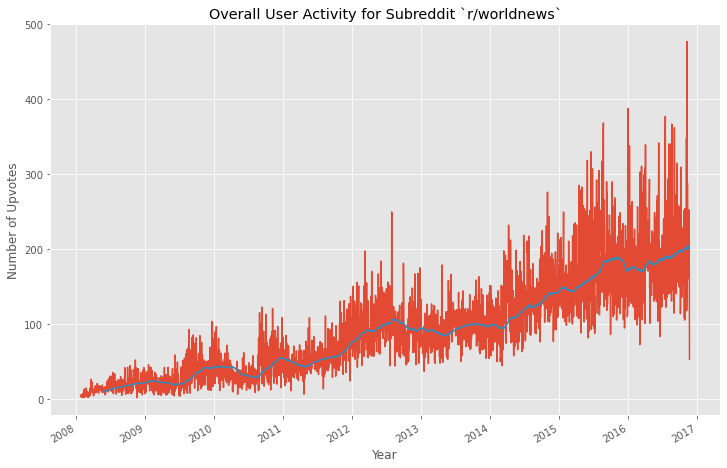

In [10]:
ax = df.groupby('date_created')['up_votes'].mean().plot()
ax = df.groupby('date_created')['up_votes'].mean().rolling(window=120).mean().plot(figsize= (12, 8))
ax.set_title('Overall User Activity for Subreddit `r/worldnews`')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Upvotes')

### 2.1.2 By year

Text(0, 0.5, 'Number of Posts')

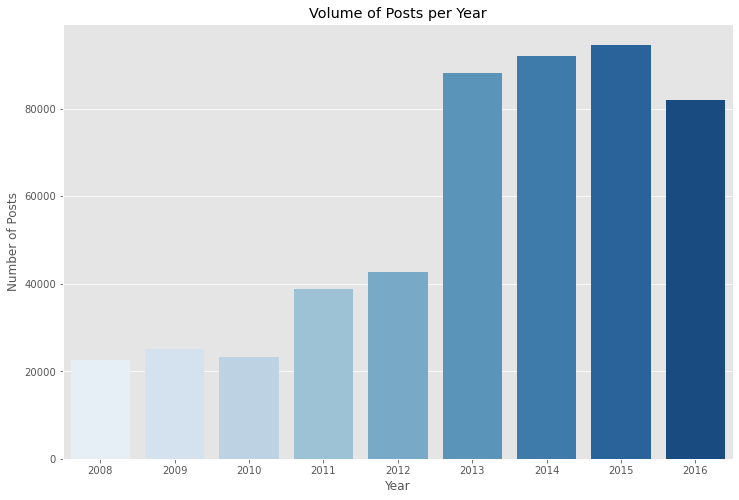

In [11]:
yearly_vol = df.groupby(df.date_created.dt.year)[['title']].count().reset_index()

fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='date_created', y='title', data=yearly_vol, palette='Blues', ax=ax)
ax.set_title('Volume of Posts per Year')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Posts')

In [12]:
vol_0810 = yearly_vol.iloc[0:3].title.mean()
vol_1112 = yearly_vol.iloc[3:5].title.mean()
vol_1316 = yearly_vol.iloc[5:].title.mean()
vol_mean = yearly_vol.title.mean()

print(f'Mean number of posts between 2008-2010: {vol_0810:.2f}')
print(f'Mean number of posts between 2011-2012: {vol_1112:.2f}')
print(f'Mean number of posts between 2013-2016: {vol_1316:.2f}')
print(f'Mean number of posts between 2008-2016: {vol_mean:.2f}')

Mean number of posts between 2008-2010: 23644.33
Mean number of posts between 2011-2012: 40764.50
Mean number of posts between 2013-2016: 89193.50
Mean number of posts between 2008-2016: 56581.78


**Observations:**
- Overall, there is a positive trend in reddit users on `r/worldnews`, with about **56,600** posts per year. However, there seem to be **three groups of years with similar post volume**:
- Between **2008-2010** there were about **23,600** posts per year.
- Between **2011-2012** there were about **40,800** posts per year.
- Between **2013-2016** there were about **89,200** posts per year.
- There seemed to be an **increased volume of posts and activity**, with **posts doubling every 2-3 years**.

## 2.2 Most reposted titles, ordered by number of times reposted and upvotes <a name="section22"></a>

In [311]:
most_reposted = df.groupby(['title'])\
    .agg({'up_votes':'sum', 'author':'count','over_18':'mean'})\
    .sort_values(by=['author', 'up_votes'], ascending = False)\
    .reset_index()

# filter out posts with only 1 author
most_reposted = most_reposted[most_reposted['author'] > 1]
most_reposted.head()

,title,up_votes,author,over_18
0,Brutality of Syrian Rebels Posing Dilemma in West,154,6,0
1,Hungarian nationalist TV camera operator filmed kicking refugee children,2635,5,0
2,South Korea reveals it has a plan to assassinate Kim Jong Un,494,5,0
3,Putin nominated for Nobel Peace Prize,295,5,0
4,Swiss tourist gang-raped in India,211,5,0
...,...,...,...,...
7720,World s oldest person Misao Okawa dead at 117 Weeks,0,2,0
7721,Young Tunisians Are Being Recruited to Jihad,0,2,0
7722,[ CEO Ryan Kavanaugh ] Relativity Media / Rogue premiere party of The Last House on the Left,0,2,0
7723,"etv online,live indian tv,ntv,live tamil tv,live tamil tv programs,tamil tv online,tamil tv programs,watch tamil tv,live etv",0,2,0


In [14]:
most_reposted_title = most_reposted.iloc[0].name

df[df['title'] == most_reposted_title]\
    .sort_values(by=['date_created'], ascending = False)

,date_created,title,author,over_18,up_votes
210805,2013-09-06,Brutality of Syrian Rebels Posing Dilemma in West,GreyMatter22,False,31
210806,2013-09-06,Brutality of Syrian Rebels Posing Dilemma in West,BillTowne,False,57
210607,2013-09-05,Brutality of Syrian Rebels Posing Dilemma in West,Jewpiter,False,19
210632,2013-09-05,Brutality of Syrian Rebels Posing Dilemma in West,0x0E,False,28
210685,2013-09-05,Brutality of Syrian Rebels Posing Dilemma in West,emr1028,False,7
210720,2013-09-05,Brutality of Syrian Rebels Posing Dilemma in West,erowidtrance,False,12


In [15]:
most_reposted.describe()[['up_votes','author']]

,up_votes,author
count,7725.000000,7725.000000
mean,167.663689,2.102395
std,633.307222,0.352546
min,0.000000,2.000000
25%,5.000000,2.000000
50%,14.000000,2.000000
75%,46.000000,2.000000
max,7593.000000,6.000000


In [133]:
most_reposted[most_reposted['up_votes'] == 7593].title

683    More than 100,000 students in Bangladesh protest against rise of Islamic extremism
Name: title, dtype: object

In [312]:
most_reposted[most_reposted.over_18 == 1].head()

,title,up_votes,author,over_18
4161,Dozens reported killed in eastern Ukraine fighting,13,2,1
6140,Video Shows Victims of Suspected Syrian Chemical Attack,5,2,1
7407,Drowned baby picture captures week of tragedy in Mediterranean,0,2,1


**Observations:** I will refer to a news topic as one that many authors posted about (reposts).
- There seem to be a relatively small number of reposts per news topic (**max 6 reposts for one topic**). 
    - Specifically for the news topic on 'Brutality of Syrian Rebels...', the two authors who reposted the article a day after everyone else (`Greymater22` and `BillTowne`) had more upvotes than the rest (I found this funny).
- Among the reposts, there was only an **average of 168 upvotes per topic** and an **average of 2 authors per reposted news topics**.
- The **most viewed topic** was about a Bangladeshi protest against Islamic extremism, and **had a total of 7,593 upvotes** between the two reposts.
- There are only three news topics that are categorized as `over_18`.

## 2.3 Author popularity and activity <a name="section23"></a>

### 2.3.1 Most popular authors

In [53]:
author_activity = df.groupby(['author'])\
    .agg({'up_votes':'sum', 'title':'count', 'over_18':'mean'})\
    .reset_index()

In [10]:
most_liked_authors = author_activity\
    .sort_values(by='up_votes', ascending = False)\
    .reset_index()\
    .head(10)

Text(0.5, 1.0, 'Most up-voted authors')

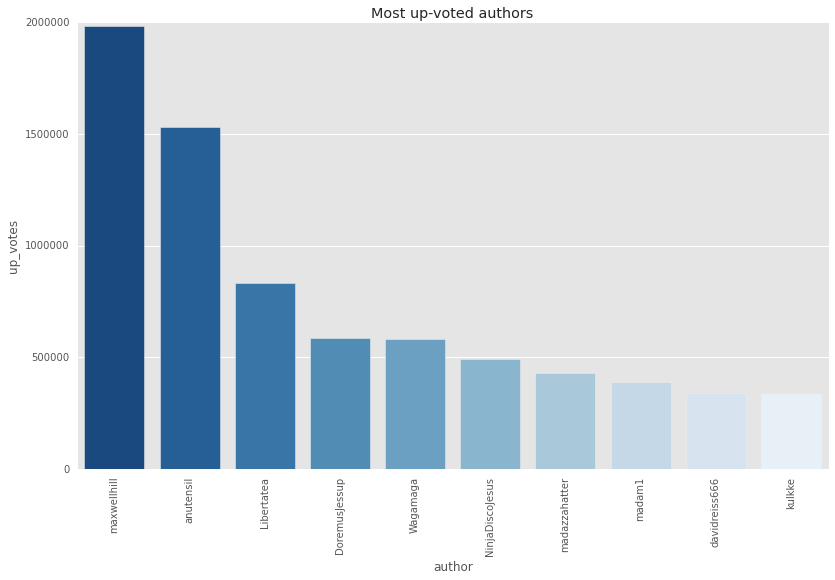

In [353]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='author', y='up_votes', 
            data=most_liked_authors,
            palette='Blues_r')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Most up-voted authors')

In [347]:
print(f'`maxwellhill`:   {most_liked_authors.iloc[0].up_votes} upvotes.')
print(f'`davidreiss666`: {most_liked_authors.iloc[8].up_votes} upvotes.')

`maxwellhill`:   1985416 upvotes.
`davidreiss666`: 338306 upvotes.


## 2.3.2 Busiest authors

In [354]:
most_active_authors = author_activity\
    .sort_values(by=['title', 'up_votes'], ascending = False)\
    .reset_index()\
    .head(10)

Text(0.5, 1.0, 'Number of posts per authors')

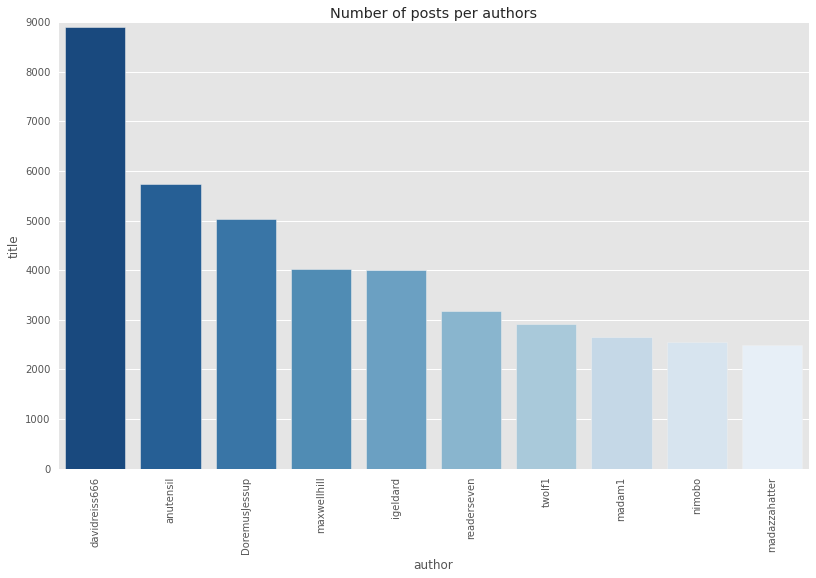

In [355]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='author', y='title', 
            data=most_active_authors,
            palette='Blues_r')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Number of posts per authors')

In [345]:
print(f'`davidreiss666`: {most_active_authors.iloc[0].title} posts.')
print(f'`maxwellhill`:   {most_active_authors.iloc[3].title} posts.')

`davidreiss666`: 8897 posts.
`maxwellhill`:   4023 posts.


### 2.3.3 Correlations

In [372]:
col1 = author_activity['up_votes']
col2 = author_activity['title']
col3 = author_activity['over_18']

print(f'The correlation between up_votes and posts by authors is {col1.corr(col2):.4f}.')
print(f'The correlation between up_votes and over_18 is {col1.corr(col3):.4f}.')

The correlation between up_votes and posts by authors is 0.6997.
The correlation between up_votes and over_18 is -0.0000.


**Observations:**
- The most liked author is `maxwellhill` with **1,985,416 upvotes** over **4,023 posts**.
- The second most liked author is `davidreiss666` with **338,306 upvotes** over **8,897 posts**.
- Although `davidreiss666` had about **2.25 times more posts** than `maxwellhill`, he received only **17% of the upvotes** that `maxwellhill` received. 
- There is a **correlation coefficient of 0.70** (moderate-strong) **between number of posts by an author and number of upvotes** they may receive. 
- There is no correlation between `up_votes` and `over_18`, however, this may be due to the small sample size of `over_18` articles.

## 2.4 Best posts per year <a name="section24"></a>

In [143]:
# create new column for year created
df['year_created'] = df['date_created'].dt.year

In [144]:
# aggregate articles by year
df_title = df.groupby(['year_created', 'title'])\
    .agg({'up_votes':'sum', 'author':'count'})\
    .reset_index().set_index('year_created')

df = df.drop(['year_created'], axis=1)

# find max number of upvotes per year
df_year_wise_maxupvotes = df_title.groupby(['year_created'])\
    .agg({'up_votes':'max'})\
    .reset_index().set_index('year_created')

merged_df = df_title.merge(df_year_wise_maxupvotes, on=['year_created', 'up_votes'])\
    .sort_values(by=['year_created'], ascending = True)

merged_df

,title,up_votes,author
year_created,,,
2008,"Today Israel takes down an entire apt building of civilians to kill the family of one man. In Canada, we call that terrorism.",1856,1
2009,How do I know China wrecked the Copenhagen deal? I was in the room.,3392,1
2010,"Dear World, The Chinese government stole intellectual property from us and others. The censorship is crazy over there and we are seriously considering ceasing our Chinese operation. - signed google.",3187,1
2011,North Korea Leader Kim-Jong Il has died,4142,1
2012,"Canada creates $5,000 cap on liability for file sharing lawsuits",7457,1
2013,"What we have... is... concrete proof of U.S.-based... companies participating with the NSA in wholesale surveillance on us, the rest of the world, the non-American, you and me, Mikko Hypponen, chief research officer at Finnish software security firm F-Secure.",10159,1
2014,"NASA officially announces Manned Mars Mission, test launch will begin tomorrow testing orbiter.",9303,1
2015,"A biotech startup has managed to 3-D print fake rhino horns that carry the same genetic fingerprint as the actual horn. The company plans to flood Chinese rhino horn market at one-eighth of the price of the original, undercutting the price poachers can get and forcing them out eventually.",21253,1
2016,"2.6 terabyte leak of Panamanian shell company data reveals how a global industry led by major banks, legal firms, and asset management companies secretly manages the estates of politicians, Fifa officials, fraudsters and drug smugglers, celebrities and professional athletes.",13244,1


In [145]:
votes_0810 = merged_df.iloc[0:3].up_votes.mean()
votes_1112 = merged_df.iloc[3:5].up_votes.mean()
votes_1316 = merged_df.iloc[5:].up_votes.mean()
votes_mean = merged_df.up_votes.mean()

print(f'Mean upvotes among best posts between 2008-2010: {votes_0810:.0f}')
print(f'Mean upvotes among best posts between 2011-2012: {votes_1112:.0f}')
print(f'Mean upvotes among best posts between 2013-2016: {votes_1316:.0f}')
print(f'Mean upvotes among best posts between 2008-2016: {votes_mean:.0f}')

Mean upvotes among best posts between 2008-2010: 2812
Mean upvotes among best posts between 2011-2012: 5800
Mean upvotes among best posts between 2013-2016: 13490
Mean upvotes among best posts between 2008-2016: 8221


**Observations:**
- The most liked content has on average 8,221 upvotes.
- We see here there is a similar trend to what we saw in [Section 2.1.2](#section21), where the average number of upvotes doubles every 2-3 years.
- These topics seem to be about **politics, fraud, surveillance, and science**.

## 2.5 Adult Content <a name="section25"></a>

In [128]:
adult_counts = df['over_18'].value_counts()
adult_counts

0    508916
1       320
Name: over_18, dtype: int64

In [136]:
df.groupby('over_18')['up_votes'].describe()

,count,mean,std,min,25%,50%,75%,max
over_18,,,,,,,,
0,508916.0,112.067681,541.169934,0.0,1.00,5.0,16.00,21253.0
1,320.0,380.375000,1062.401351,0.0,1.75,8.0,117.25,7941.0


In [129]:
print(f'NSFW posts are {100 * adult_counts[1]/df.shape[0]:.2f}% of the dataset')

NSFW posts are 0.06% of the dataset


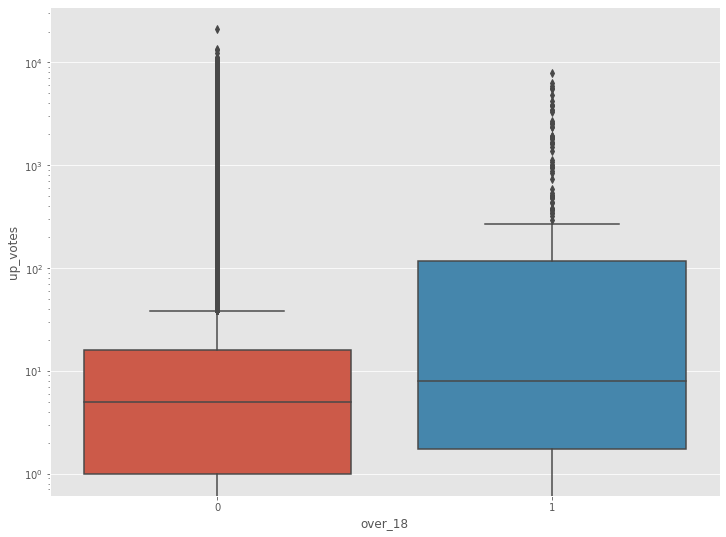

In [130]:
ax = sns.boxplot(x="over_18", y="up_votes", data=df)
ax.set_yscale("log")

In [131]:
df[df['over_18'] == True]\
    .sort_values(by=['up_votes'], ascending = False)\
    .head(5)

,date_created,title,author,over_18,up_votes,compound,sentiment,key_words
500590,2016-10-18,"Judge presiding over El Chapo s case shot, killed while jogging outside home",IsleCook,1,7941,-0.6705,neg,"[judge, presiding, el, chapo, case, shot, killed, jogging, outside, home]"
494536,2016-09-25,"[NSFL] Australian child molester Peter Scully faces death penalty in Philippines - Scully filmed his torture and rape of young girls as he made them dig their own graves and laughed, joked and acted nonchalant about his alleged crimes",ExWhySaid,1,6322,-0.9493,neg,"[nsfl, australian, child, molester, peter, scully, faces, death, penalty, philippines, scully, filmed, torture, rape, young, girls, made, dig, graves, laughed, joked, acted, nonchalant, alleged, crimes]"
428689,2016-01-07,Armed suspect shot dead after trying to storm Paris police station,rawmas02,1,5878,-0.7579,neg,"[armed, suspect, shot, dead, trying, storm, paris, police, station]"
462067,2016-05-17,Syria Army killed over 200 ISIS militants in 3-day long offensive in Deir Ezzor,orangeflower2015,1,5617,-0.8176,neg,"[syria, army, killed, 200, isis, militants, 3, day, long, offensive, deir, ezzor]"
303900,2014-09-05,Man escapes ISIS execution,brothamo,1,5507,0.1280,pos,"[man, escapes, isis, execution]"


**Observations:**
- Even though NSFW articles account for only 0.06% of the posts in this dataset, the have a higher average number of upvotes than SFW articles.

## 2.6 Summary <a name="section26"></a>

Overall, we see a **positive trend in both volume of posts and number of upvotes** in the subreddit `r/worldnews` between the years 2008 and 2016. More specifically, we see that **user activity seems to double every 2-3 years**. It looks like topics that get more foot-traffic (upvotes) aren't necessarily the reposts. Rather, there are only **7,725 articles that were reposted** (about 2% of the entire dataset), with about **2 authors per reposted article**. When combining all the upvotes per reposted article, we see only an average of 168 upvotes per topic. Additionally, there were only three news topics that were categorized as `over_18`. 

We found the most liked author in this time period was `maxwellhill`, with **1,985,416 upvotes** over **4,023 posts**. There does seem to be a moderate-strong correlation (0.70) between number of posts by an author and total number of upvotes; however, the author `davidreiss666` (most number of posts) had about **2.25 times more posts** than `maxwellhill`, he received only **17% of the upvotes** that `maxwellhill` received. Moreover, after a (shallow) lookthrough of the most interesting articles per year, they seem to revolve around **politics, fraud, surveillance, and science**. Lastly, even though NSFW content accounts for only 0.06% of the dataset, these articles have on average more upvotes (380 $\pm$ 1062 upvotes) than SFW content  (112 $\pm$ 541 upvotes).

However, I would like to do more in-depth analysis of the titles and gain a better understanding the differences between topics shared by popular authors vs non-popular authors (low total upvote count). I would also like to see the most frequent words used in the most liked news articles. This could give us a better idea of what topics catch the public's eye. 

In the next two sections, I will extract text features, sentiment and key words, and use a self-built search-engine to help query and visualize news sentiment for specific topics.

[Return to Table of Contents](#toc)

# 3.0 Text Features and Tools <a name="section3"></a>

In this section, I will find the **sentiment** and **key words** of each title. Title sentiment is a great metric to gauge how emotional content is perceived by users. Breaking the titles into their key words can make it easier for us to search for occurrances of specific topics in titles, such as `North Korea` or `US economy`.

In [11]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn import preprocessing

import itertools
from PIL import Image
from wordcloud import WordCloud

In [27]:
''' ONLY NEED TO DOWNLOAD PACKAGES ONCE '''
nltk.download(['stopwords','vader_lexicon'])

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/viggyravi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/viggyravi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/viggyravi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/viggyravi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 3.1 Extract compound sentiment <a name="section31"></a>

To find sentiment, I will use the nltk built-in, pretrained sentiment analyzer **VADER** (**V**alence **A**ware **D**ictionary and s**E**ntiment **R**easoner). It is a rule-based sentiment analyzer, and uses a list of lexicon features (words), which are labeled positive or negative, to calculate a sentence's sentiment. It returns the probability of a given input to be either positive, negative, or neutral. It also computes a **compound score** of the three values, where a positive sentiment is a score of $[0.05, 1]$,  a negative sentiment is a score of $[-1, -0.05]$, and a neutral sentiment a score of $(-0.05, 0.05)$, where brackets are inclusive and parentheses are non-inclusive ([ref](https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/)).

There are many other rule-based sentiment analysis APIs out there (ex. SpaCy's TextBlob) and even machine learning sentiment analyzer, however, VADER is a simple to use tool built for social media analysis, so it will be sufficient for this report. 

In [12]:
# create nltk sentiment analyzer object 
sid = SentimentIntensityAnalyzer() 

# find (compound) title sentiment using polarity_scores
%time sentiment = [sid.polarity_scores(title)['compound'] for title in df.title]  

CPU times: user 2min 23s, sys: 7.91 s, total: 2min 31s
Wall time: 2min 32s


In [13]:
# append data to dataframe
df['compound'] = sentiment
df.head()

,date_created,title,author,over_18,up_votes,compound
0,2008-01-25,Scores killed in Pakistan clashes,polar,0,3,-0.6705
1,2008-01-25,Japan resumes refuelling mission,polar,0,2,0.0000
2,2008-01-25,US presses Egypt on Gaza border,polar,0,3,0.0000
3,2008-01-25,Jump-start economy: Give health care to all,fadi420,0,1,0.4939
4,2008-01-25,Council of Europe bashes EU&UN terror blacklist,mhermans,0,4,-0.5267


In [252]:
import numpy as np

# create sentiment categories based on compound score
conditions = [
    (df['compound'] >= 0.05),
    (df['compound'] > -0.05) & (df['compound'] < 0.05),
    (df['compound'] <= -0.05)    
]

values = ['pos','neu','neg']

df['sentiment'] = np.select(conditions, values)

df.head()

,date_created,title,author,over_18,up_votes,compound,sentiment,key_words
0,2008-01-25,Scores killed in Pakistan clashes,polar,0,3,-0.6705,neg,"[scores, killed, pakistan, clashes]"
1,2008-01-25,Japan resumes refuelling mission,polar,0,2,0.0000,neu,"[japan, resumes, refuelling, mission]"
2,2008-01-25,US presses Egypt on Gaza border,polar,0,3,0.0000,neu,"[us, presses, egypt, gaza, border]"
3,2008-01-25,Jump-start economy: Give health care to all,fadi420,0,1,0.4939,pos,"[jump, start, economy, give, health, care]"
4,2008-01-25,Council of Europe bashes EU&UN terror blacklist,mhermans,0,4,-0.5267,neg,"[council, europe, bashes, eu, un, terror, blacklist]"


## 3.2 Title key words <a name="section32"></a>

To find title key words, I will be using the nltk `Regexp Tokenizer` with specified regular expressions to 1) parse the titles and 2) keep important punctuation/terms (ex reddit page mentions '/r/' and hashtags '#'). I will also remove any unnecessary stopwords by checking the key words agains the nltk `stopwords.words('english')` list, the `string.punctuation` list, and some additional words I noticed didn't provide much meaning, but still had high word frequency.  

I decided to use my own regular expressions rather than using the nltk built-in `word_tokenize` to parse the titles, because the built-in tokenizer removed some important punctuations/terms (like reddit page mentions (`/r/`) and hashtags (`#syria`)) and kept some unwanted punctuation (ex. `economy:`). I thought it was important to have an accurate representation of key words of news headlines for any future analysis.

In [17]:
# Step 0: get stopwords
stopwords = stopwords.words('english') + list(string.punctuation)
stopwords = stopwords + ['”', '“', '’', '‘', 'nsfw', 'nsfl', 'say', 'says', 'new']

In [18]:
# Step 1: create regexp tokenizer
# SEE EXAMPLE CASES IN APPENDIX B
re1 = r"\w+"      # words only
re2 = r"\$[,\d.]*" # dollars
re3 = r"#[\w+]*"  # hashtags
re4 = r"\/[r]/"   # subreddits tags

generic_re = re.compile("(%s|%s|%s|%s)" % (re1, re2, re3, re4))

Regular expressions are useful for parsing strings for elements that we need. The four regular expressions I defined above parse strings for `words only`, `dollar signs`, `hashtags`, and `subreddit mentions`. I created the first regular expression to **remove unwanted punctuation stuck to words** (ex. `economy:`). The second regular expression divides money-related terms into two terms: **amount and description**. I thought by doing this, it would be easier to search for money-related articles (by searching for specific values) or for descriptors (by searching for `billion`, `m`, etc.). The third regular expression ensures that all **hashtags stay intact** (ex. `#syria` instead of `#` and `syria`). The last regular expression divides reddit page mentions into two terms: **`/r/` and the category** (ex. politics, worldnews, etc.). 

See examples of how the regular expressions work below.

In [19]:
# Step 1.1: example regexp cases

# define new tokenizer
test = nltk.RegexpTokenizer(generic_re)

# test strings
test_remove = "economy: !!! .... \x07illegal"
test_dollar = "$1,000,000 $1m $17.5billion $125/each! $16-billion-a-year  $13(£8) $100+m/year"
test_hashred = "(#syria) #48kmarch: /r/legalnews" 

# they work!
print(test.tokenize(test_remove))
print(test.tokenize(test_dollar))
print(test.tokenize(test_hashred))

['economy', 'illegal']
['$1,000,000', '$1', 'm', '$17.5', 'billion', '$125', 'each', '$16', 'billion', 'a', 'year', '$13', '8', '$100', 'm', 'year']
['#syria', '#48kmarch', '/r/', 'legalnews']


In [20]:
# Step 2: find key words (tokenize and lemmatize titles)
tkzr = nltk.RegexpTokenizer(generic_re)
# ltzr = WordNetLemmatizer()

def find_key_words(df_titles):    
    # remove dots (ex U.S. -> US) and tokenize
    tokens = df_titles.replace(r'\.','',regex=True).map(tkzr.tokenize)

    # remove stopwords
    for i, title in enumerate(tokens):
        tokens[i] = [w.lower() for w in title if w.lower() not in stopwords]
        
    return tokens

In [21]:
# find key words
%time key_words = find_key_words(df.title)

CPU times: user 50.7 s, sys: 656 ms, total: 51.3 s
Wall time: 51.9 s


In [22]:
# append data to dataframe
df['key_words'] = key_words
df.head()

,date_created,title,author,over_18,up_votes,compound,sentiment,key_words
0,2008-01-25,Scores killed in Pakistan clashes,polar,0,3,-0.6705,neg,"[scores, killed, pakistan, clashes]"
1,2008-01-25,Japan resumes refuelling mission,polar,0,2,0.0000,neu,"[japan, resumes, refuelling, mission]"
2,2008-01-25,US presses Egypt on Gaza border,polar,0,3,0.0000,neu,"[us, presses, egypt, gaza, border]"
3,2008-01-25,Jump-start economy: Give health care to all,fadi420,0,1,0.4939,pos,"[jump, start, economy, give, health, care]"
4,2008-01-25,Council of Europe bashes EU&UN terror blacklist,mhermans,0,4,-0.5267,neg,"[council, europe, bashes, eu, un, terror, blacklist]"


## 3.3 Search Engine <a name="section33"></a>

`search` takes in a string or a list of strings, and sorts the individual terms into two categories: `find_all` and `find_any`. If terms are placed in the first category, then all terms must be present in a title for the article (row) to be returned (ex. `north` and `korea`). If terms are placed in the second category, then any one term can be present in a title for the article (row) to be returned (ex. `elon` or `musk`). The search-engine can handle a small combination of the two categories as well (ex. `united` and `states` or `us`).

In [ ]:
def search(phrases):
    
    find_all = []
    find_any = []
    
    for phrase in phrases:
        # check if phrase contains multiple words
        if ' ' in phrase: 
            phrase = re.sub(r'\.','',phrase).lower()
            find_all.extend(phrase.split())
        else: # just a single-word search
            phrase = re.sub(r'\.','',phrase).lower()
            find_any.append(phrase)
    
    # mini-hack: if no multi-word searches,
    # add ' ' so search engine won't return 
    # all rows
    if not find_all: find_all.append(' ')
    
    return df.loc[key_words.map(lambda sent: any(wd in sent for wd in find_any) or all(wd in sent for wd in find_all))]

In [ ]:
# example 1: U.S. or united states
search(['united states','U.S'])[30:35]

In [ ]:
# example 2: north korea
search(['north korea']).head()

[Return to Table of Contents](#toc)

# 4.0 Sentiment Analysis <a name="section4"></a>

Okay now for the moment we've all been waiting for...sentiment plots! Up until now, we have explored the dataset for user activity, author statistics, popular articles, and nsfw articles. We also created text features, like sentiment and key words, as well as a pretty neat search-engine to find topics of interest. We now have all the tools to delve into the dataset and see what trends exist among frequent topics.

## 4.1 Word Frequency and Sentiment Plots <a name="section41"></a>

In [358]:
def plot_pie_sentiment_pipeline(dfp, title, colors=['tab:red','tab:purple','tab:blue']):
    fig, axes = plt.subplots(1, 2, figsize=(20,10))   
       
    df_plot = dfp.groupby([dfp.date_created.dt.year, 'sentiment'])[['up_votes']].mean().reset_index()
    sns.lineplot(x='date_created', y='up_votes',
                hue = 'sentiment',
                data=df_plot,
                palette=colors,
                ax=axes[0])
    sns.regplot(x='date_created', y='up_votes', 
                data=df_plot, ax=axes[0], line_kws={"color": "black"})
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Average Upvotes')
    axes[0].set_title(title+': Average Yearly Upvotes for Pos, Neu, and Neg Articles')
    
    axes[1] = dfp.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', 
                  colors=['tab:red','tab:purple','tab:blue'], fontsize=16)
    axes[1].set_title(title+': Proportion of Pos, Neu, and Neg Articles')
    
    plt.show()

In [289]:
def wordcloud_plot(tokens, title):
    wc = WordCloud(background_color='white', max_words=100).generate(' '.join(tokens))

    plt.figure(figsize=(15,10))
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title)
    plt.show()

In [24]:
# function to fatten all key words
flatten = lambda key_words: [word for title_kw in key_words for word in title_kw]

### 4.1.1 Overall sentiment

There are a total of 5181720 key words


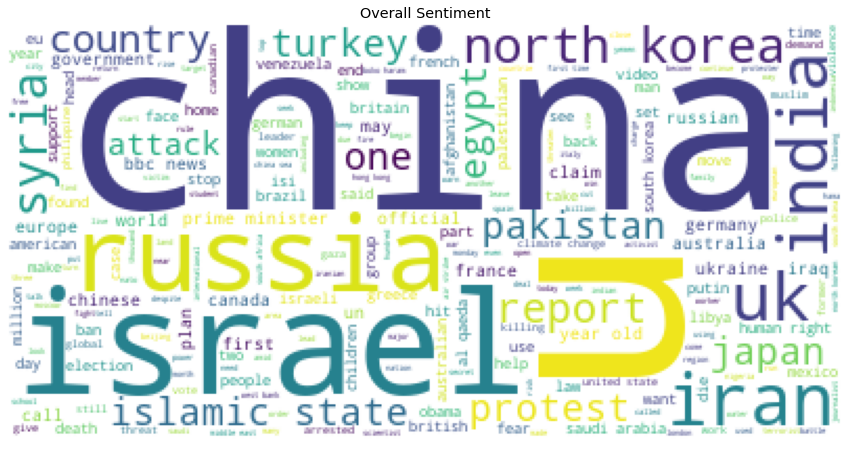

In [270]:
# flatten all tokens
all_tokens = flatten(key_words)
print(f'There are a total of {len(all_tokens)} key words')

wordcloud_plot(all_tokens, 'Overall Most Frequent Words')

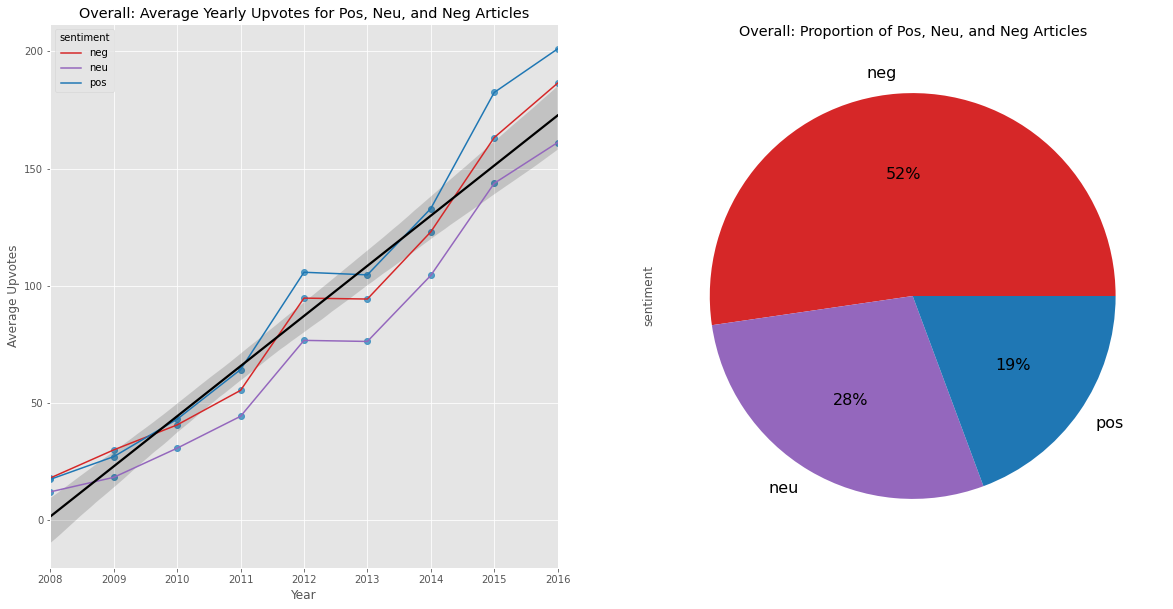

In [359]:
plot_pie_sentiment_pipeline(df, 'Overall')

### 4.1.2 Best authors statistics

In [278]:
# find 99% cutoffs (cumulative upvotes)
author_activity.quantile(0.99)

up_votes    9339.67
title         73.00
over_18        0.00
Name: 0.99, dtype: float64

In [319]:
# find top authors
top_authors = author_activity[author_activity['up_votes'] > 9340].author
top_authors.shape

(859,)

In [320]:
# subset of df of only top authors
df_top_authors = df[df['author'].isin(top_authors)]
df_top_authors.shape

(202005, 8)

There are a total of 2518593 key words


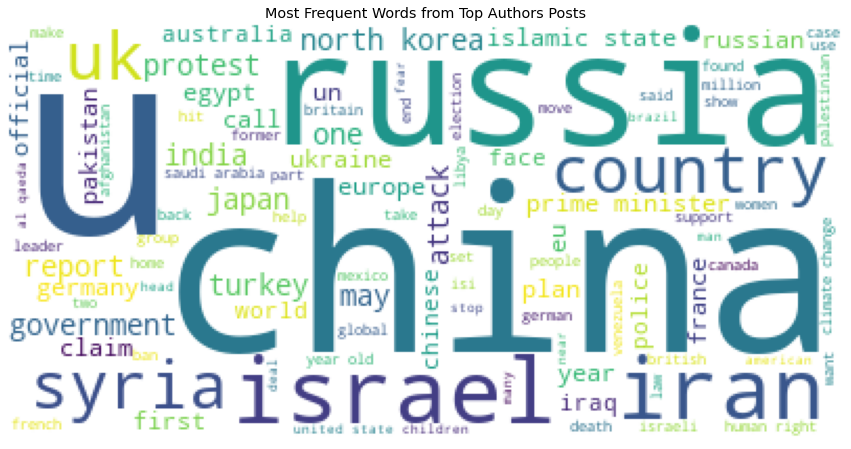

In [321]:
# get flattened key words
top_authors_tokens = flatten(df_top_authors.key_words)
print(f'There are a total of {len(top_authors_tokens)} key words')

wordcloud_plot(top_authors_tokens, 'Most Frequent Words from Top Authors Posts')

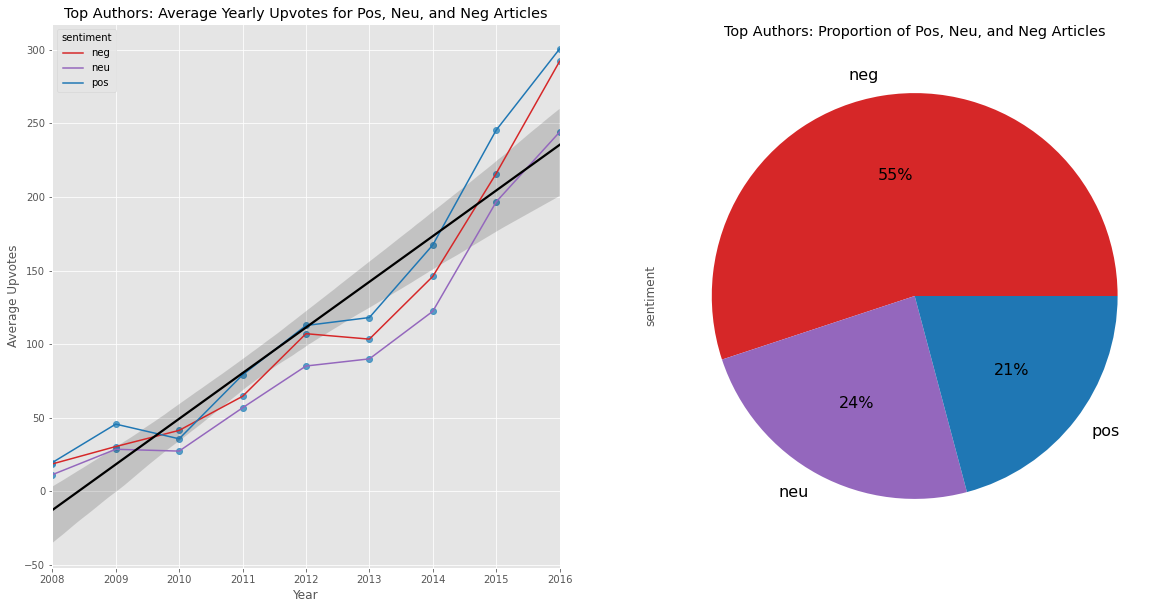

In [360]:
plot_pie_sentiment_pipeline(df_top_authors, 'Top Authors')

### 4.1.3 Best posts statistics

In [279]:
df.quantile(0.99)

over_18        0.0000
up_votes    2960.6500
compound       0.7717
Name: 0.99, dtype: float64

In [324]:
df_best_posts = df[df['up_votes'] > 2960]
df_best_posts.shape

(5093, 8)

There are a total of 65842 key words


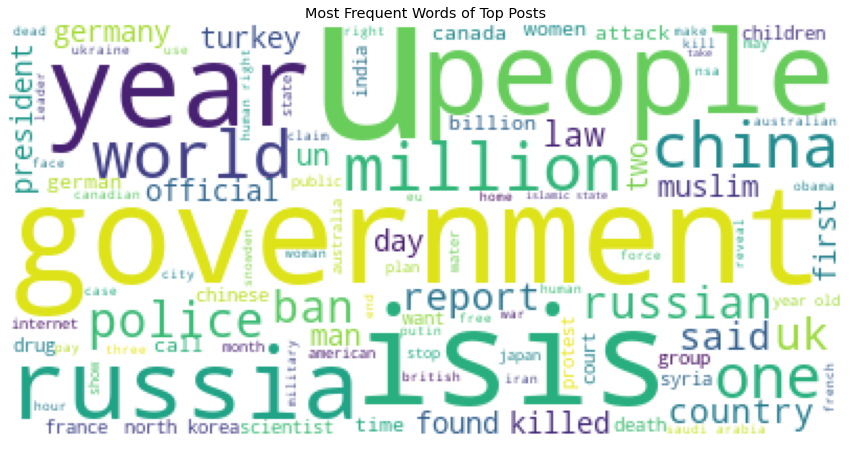

In [325]:
# flatten key words
best_posts_tokens = flatten(df_best_posts.key_words)
print(f'There are a total of {len(best_posts_tokens)} key words')

wordcloud_plot(best_posts_tokens, 'Most Frequent Words of Top Posts')

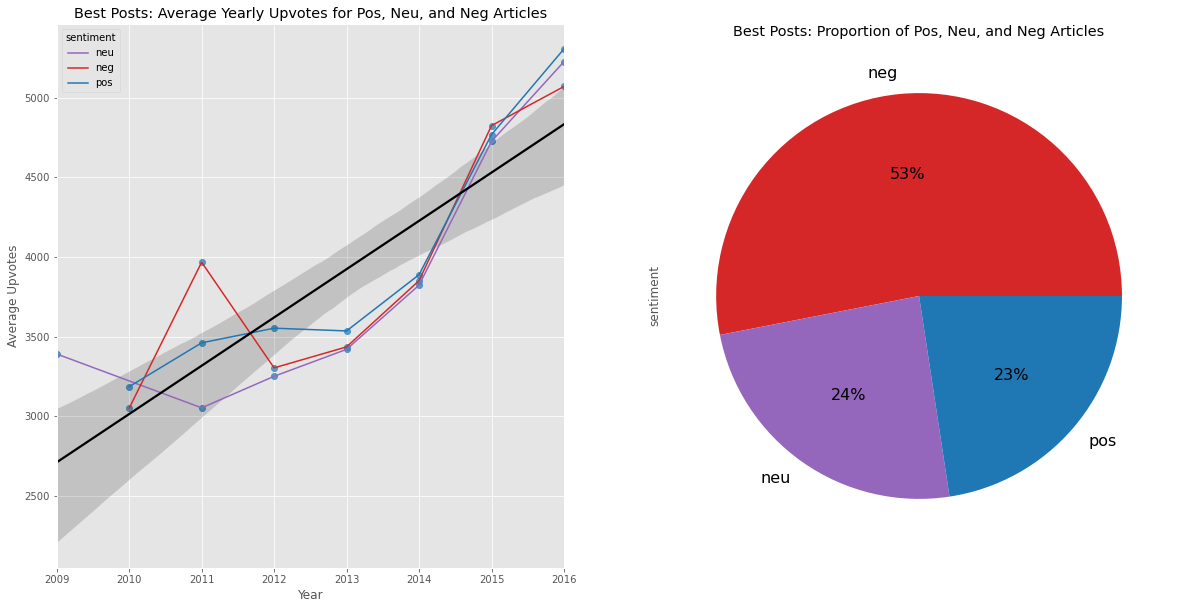

In [361]:
plot_pie_sentiment_pipeline(df_best_posts, 'Best Posts', colors=['tab:purple','tab:red','tab:blue'])

### 4.1.4 Bottom 25% of posts

In [338]:
df_worst_posts = df.query('up_votes <= 1')
df_worst_posts.shape

(140174, 8)

There are a total of 1268411 key words


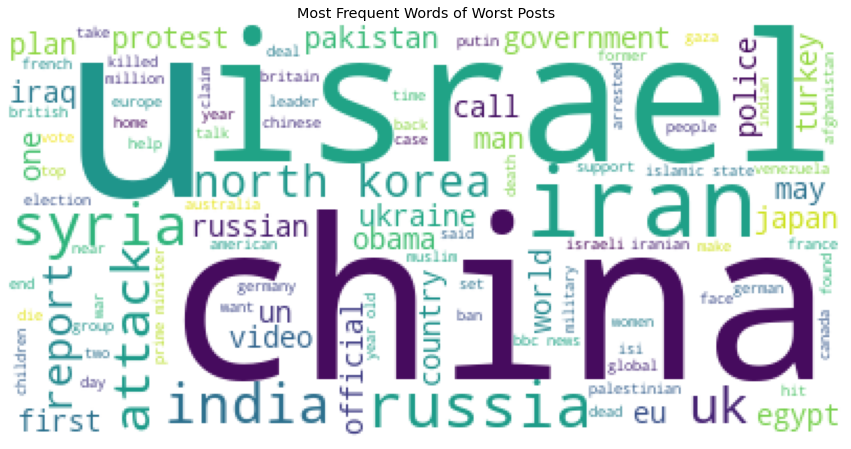

In [339]:
# flatten key words
worst_posts_tokens = flatten(df_worst_posts.key_words)
print(f'There are a total of {len(worst_posts_tokens)} key words')

wordcloud_plot(worst_posts_tokens, 'Most Frequent Words of Worst Posts')

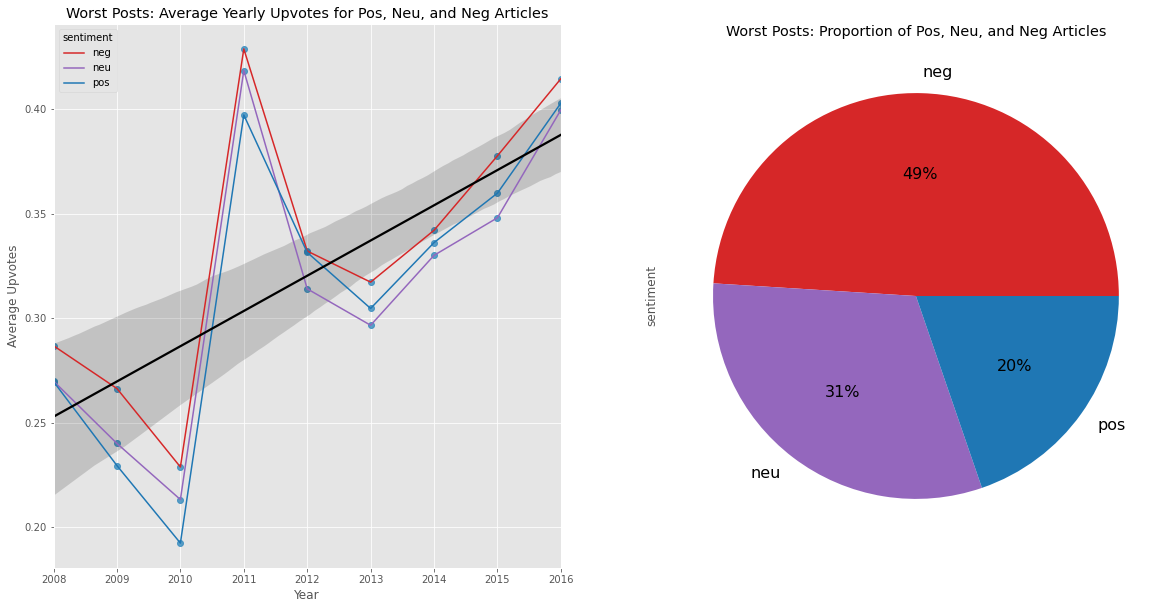

In [362]:
plot_pie_sentiment_pipeline(df_worst_posts, 'Worst Posts')

### 4.1.5 Graphic posts

In [284]:
# isolate adult content
df_nsfw = df[df.over_18 == 1]

In [285]:
# flatten key words
nsfw_tokens = flatten(df_nsfw.key_words)
print(f'There are a total of {len(nsfw_tokens)} key words')

There are a total of 5178577 key words
There are a total of 3143 key words


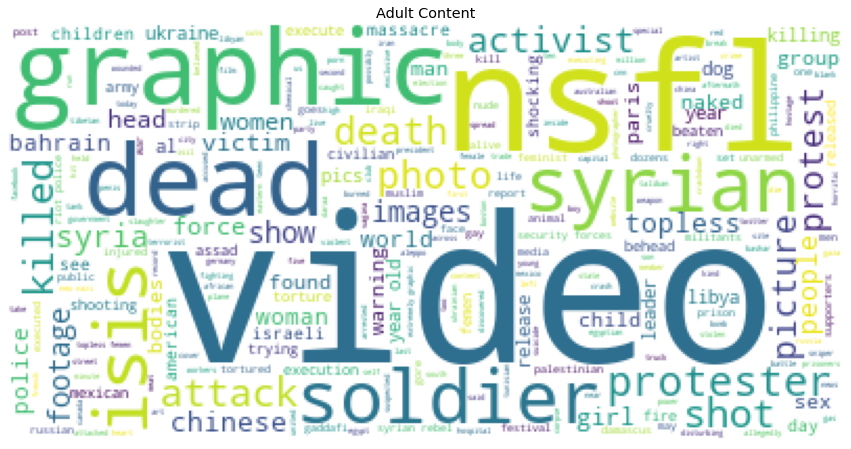

In [287]:
wordcloud_plot(nsfw_tokens, 'Most Frequent Words in Adult Content Articles')

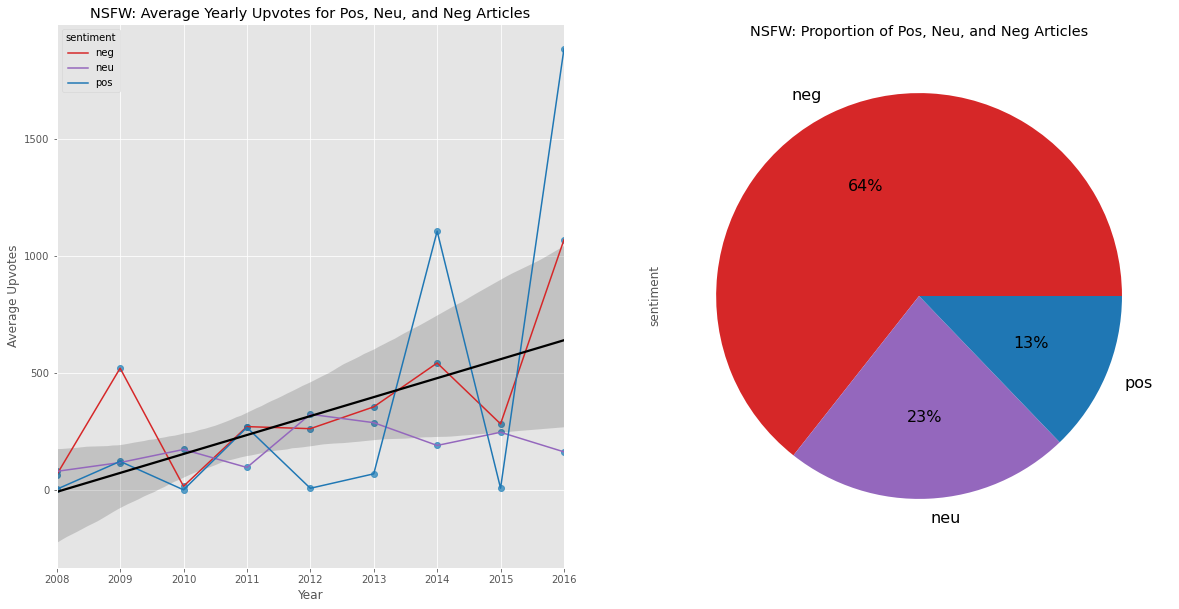

In [363]:
plot_pie_sentiment_pipeline(df_nsfw, 'NSFW')

In [309]:
df_nsfw.query('compound > 0.05 & date_created.dt.year == 2016').sort_values('compound', ascending=False).head()

,date_created,title,author,over_18,up_votes,compound,sentiment,key_words
494947,2016-09-27,Paris to create designated space for naked people as plans for nudist park approved,n0k1man,1,1855,0.5994,pos,"[paris, create, designated, space, naked, people, plans, nudist, park, approved]"
508176,2016-11-18,Animal welfare activists have released footage of a heavily policed Spanish festival in which a live bull is caked in mud and set alight.,NinjaDiscoJesus,1,0,0.4939,pos,"[animal, welfare, activists, released, footage, heavily, policed, spanish, festival, live, bull, caked, mud, set, alight]"
461255,2016-05-13,ISIS massacre 14 Real Madrid fans at supporters club in Baghdad,PeterG92,1,4839,0.4404,pos,"[isis, massacre, 14, real, madrid, fans, supporters, club, baghdad]"
494006,2016-09-22,ISIS shoots and beheads spies with help of child,JahanzaibRao,1,846,0.4019,pos,"[isis, shoots, beheads, spies, help, child]"


## 4.2 Sentiment over time <a name="section42"></a>

In [ ]:
def get_search_dfs(topics, cols, agg):
    dfs = []
    for topic in topics:
        if topic == 'baseline':
            temp_df = df.groupby(df.date_created.dt.year)\
                .agg(agg).reset_index()
            dfs.append(temp_df)
        else:
            temp_df = search(topic)[cols]\
                        .groupby(df.date_created.dt.year)\
                        .agg(agg).reset_index()
            dfs.append(temp_df)
    return dfs

def plot_sentiment_pipeline(topics, title=''):
    cols = ['date_created','compound','up_votes']
    agg = {cols[1]:'mean', cols[2]:'mean'}
    
    dfs = get_search_dfs(topics, cols, agg)

    fig, axes = plt.subplots(1, 2, figsize=(20,10))
    fig.suptitle(title)
    
    for i,frame in enumerate(dfs):
        if topics[i] == 'baseline':
            axes[0].plot(frame['date_created'], frame[cols[1]], 
                     'k--', linewidth=6, label=topics[i])
            axes[1].plot(frame['date_created'], frame[cols[2]], 
                     'k--', linewidth=6, label=topics[i])
        else:
            axes[0].plot(frame['date_created'], frame[cols[1]], 
                     marker='o', label=topics[i])
            axes[1].plot(frame['date_created'], frame[cols[2]], 
                     marker='o', label=topics[i])
            
    axes[0].set_title('Average Compound Sentiment per Year')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Compound Sentiment')
    axes[0].legend()
    
    axes[1].set_title('Average Upvote per Year')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Average Upvote')
    axes[1].legend()

### 4.2.1 Most frequent countries

From the wordcloud, it looks like `US`, `China`, `Israel`, `Russia`, `Iran`, `India`, and `UK` are the most frequent countires. 

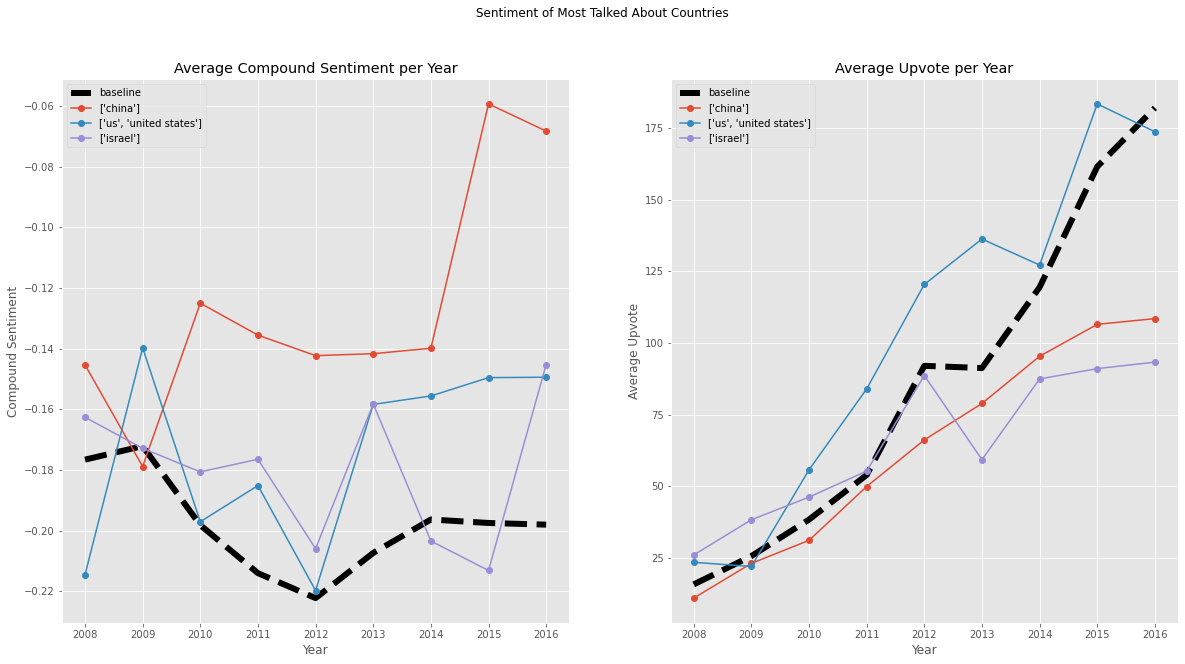

In [246]:
topics = ['baseline', ['china'],['us','united states'],['israel']]
title = 'Sentiment of Most Talked About Countries'
plot_sentiment_pipeline(topics=topics, title=title)

### 4.2.2 Energy sector

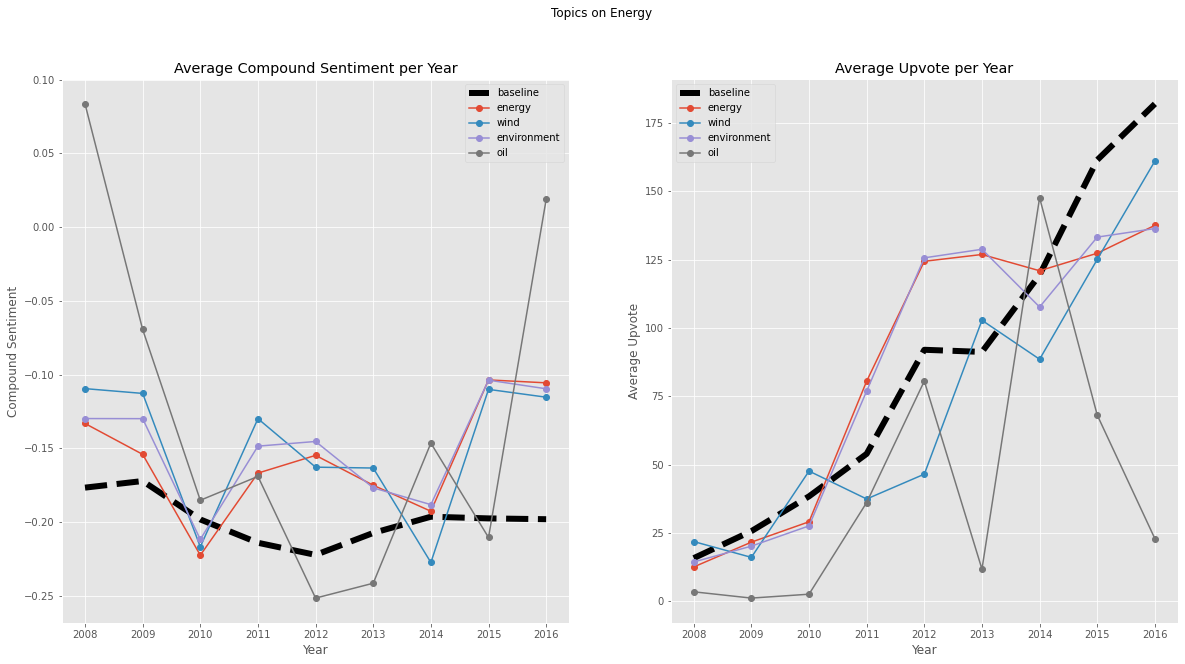

In [81]:
topics = ['baseline','energy','wind','environment','oil']
title = 'Topics on Energy'
plot_sentiment_pipeline(topics, title=title)

## 4.3 Summary <a name="section43"></a>

In [Section 4.1](#section41), we see the overall sentiment and upvote trends for the entire dataset as well as subsets of the dataset. The proportion of **negative, neutral, and positive articles** in this dataset are **52%, 28%, and 19%** respectively. Interestingly, there positive articles have, on average, more upvotes than negative and neutral articles (in that order).

The 859 `best authors`(top 1%) seem to follow **similar trends** in proportions of negative (55%), neutral (24%), and positive (21%) articles, and upvote trends for each sentiment when compared **to the entire dataset** (pos > neg > neu). 

Of the `best posts` (top 1%), there seems to be **similar proportions** of negative (53%), neutral (24%), and positive (23%) articles when compared to the overall dataset; however, there doesn't seem to be a distinction between upvotes for negative, neutral, and positive articles. Of the `worst posts` (bottom 25%), we now see a **larger proportion of neutral articles (31%) and smaller proportion of negative articles (49%)**. Moreover, we see negative articles have, on average, more upvotes than positive or neutral articles (in that order). 

Lastly, `adult content` has the most drastic change in the proportion of negative (64%), neutral (23%), and positive (13%) articles. Interestingly, although user activity/upvotes doubles every 2-3 years, we see that the average upvotes for `adult content` stays relatively the same, with only marginal growth of upvotes every year. In other words, the number of **average upvotes tends to stay the same over time**. I will note that we saw spikes in upvotes for positive articles in the years 2014 and 2016; however, when looking deeper into what articles were rated so highly, I found that the VADER sentiment analyzer incorrectly classified the sentiment for some articles. For example, `ISIS shoots and beheads spies with help of child` has a compound sentiment score of `0.4019` most likely due to the word `help`, however, VADER failed to take into context of the entire sentence. 

In [Section 4.2](#section42), we see how sentiment over time provides us more insight to how different countries or groups of related topics are perceived over time. From the first plot, we see that `US` and `Israel` have similar sentiments over time, while `China` has higher relative sentiments that the other two countries. In the last plot, we see that groups of related search words - `energy`,`wind`,`environment`,`oil` - seem to follow similar trends in both sentiment and upvotes. However, we can see how `oil` is more volatile in both sentiment and upvotes in comparison to the other search words.   

Some other topics I looked into:
- Science = ('baseline','genetic','health','cancer')
- Health = ('baseline','malaria','hiv','SARS','MERS')
- Space/Technology = ('baseline','elon','nasa','space','technology')

[Return to Table of Contents](#toc)

# 5.0 Discussion <a name="section5"></a>

Overall, the exploratory data analysis and the evaluation of sentiment in the `r/worldnews` dataset has provided us with some insight about specific topics as well as the users. We first found that user activity is increasing at a steady rate, almost doubling in the number of posts every 2-3 years. We saw that reposts aren't necessarily the most interesting topics out there, with a low average upvote count overall (about 167 upvotes for all reposts combined). Rather, reddit viewers seemed to gravitate towards certain authors, such as `maxwellhill`. When looking deeper into the data, we found that there is a moderate-strong correlation between the volume of posts by an author and the number of upvotes, however, it isn't always true (ex. `davidreiss666`). Lastly, it was no surprise that NSFW content, which represents just 0.06% of the dataset, had an average upvote of 380, more than tripple that of SFW content. I believe this value might be under-represented, as I noticed a lot of titles in this dataset that were not labeled `True` for `over_18`. This might be an area of improvement in the future.

Next, we found that we could use VADAR and a search tool to examine the sentiment of topics over time. First, we found that roughly 50% of news articles in this dataset were calculated to have negative sentiment. This makes sense for the type of data we are looking into, as news typically tends to be more negative in nature. However, it is important to note that positive articles tend to have more upvotes on average, even though they only acount for about a quarter of the entire dataset. When looking at subsets of the dataset - `most liked authors`, `best posts`, `worst posts`, and `graphic posts` - we see that the most like authors have posts that closely mimic trends of the entire dataset. However, the subset of most liked articles don't have a distinction between negative, positive, and neutral content. This could be attributed to NSFW articles that tend to have negative sentiment in general and recieve more upvotes on average. The NSFW articles have the greatest variation in average upvotes. Moreover, the sentiment might see a greater number of negative upvotes when correcting sentiment scores.